In [35]:
import pandas as pd
import glob
import os 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from Bio import SeqIO
%load_ext autoreload
%autoreload 2
from helpers_barplot_intersection import plot_text, plot_intersection_bars

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# INPUTS 
read_from_disk = True # or reload
proteomicsdir = '/cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024'
#proteomicsdir = '/cluster/work/grlab/projects/projects2020_OHSU/proteomics'

pipelines = ['OHSU', 'ETH']

FDR_limit = 0.05
MS_FDR = '_crux' #choices: '_crema' '_crux' or ''
MS_strategy = 'pool' #Choices: 'pool' 'joint', 'single' 

#pool: pool all experiments per pipeline
#joint: pool all experiments for both pipeline
#single: per experiment per pipeline

if MS_FDR == '_crema':
    FDR_file = 'crema.peptides.txt'
    col_seq = 'sequence'
    col_qvalue = 'crema q-value'
elif MS_FDR == '_crux' or  MS_FDR == '':
    FDR_file = 'assign-confidence.target.txt'
    col_seq = 'unmodified sequence'
    col_qvalue = 'tdc q-value'
else:
    print(f'ERROR: wrong input for {FDR_file}')

    

sample_plot_dir = {}
run_type_plot_dir = {}    
all_samples = []

# BRCA
samples = ['TCGA-C8-A12P-01A-11R-A115-07',
                  'TCGA-AO-A0JM-01A-21R-A056-07',
                  'TCGA-BH-A18V-01A-11R-A12D-07',
                  'TCGA-A2-A0D2-01A-21R-A034-07',
                  'TCGA-A2-A0SX-01A-12R-A084-07']
all_samples.extend(samples)
basedir = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102'
filter_dir = os.path.join(basedir, 'filtering_samples', 'filters_19May_order_5ge_wAnnot_GPstar')

for sample in samples:
    sample_plot_dir[sample] = os.path.join(filter_dir, 'plots')
    run_type_plot_dir[sample] = 'BRCA'
    
# OV
samples = ['TCGA-25-1319-01A-01R-1565-13',
                  'TCGA-25-1313-01A-01R-1565-13',
                  'TCGA-61-2008-01A-02R-1568-13',
                  'TCGA-24-1431-01A-01R-1566-13',
                  'TCGA-24-2298-01A-01R-1569-13']
all_samples.extend(samples)
basedir = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374'
filter_dir = os.path.join(basedir, 'filtering_samples', 'filters_19May_order_5ge_wAnnot_GPstar')

for sample in samples:
    sample_plot_dir[sample] = os.path.join(filter_dir, 'plots')
    run_type_plot_dir[sample] = 'OV'
    
fasta_base_OHSU = '/cluster/work/grlab/projects/projects2020_OHSU/share_OHUS_PNLL/current'
fasta_base_ETH = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/*/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar'
        #format fasta_file = f'{fasta_base_OHSU}/J_{sample}_pool_kmer.fa'
        #format fasta_file = f'{fasta_base_ETH}/G_{sample}_pool_kmer_25012024.fa.gz'

# PLOTTING Parameters 
ticks_fontsize = 12
axislabels_fontsize = 12
legend_fontsize = 12
axes_fontsize = 15
save = True
sample = None

In [8]:
def reader_assign_conf_pep(path, FDR_threshold, col_seq, col_qval):
    print(f'Reading {path}')
    if os.path.isfile(path):
        df = pd.read_csv(path, sep = '\t')
        tot_peptides = len(df[col_seq].unique())
        print(f'With Shape: {df.shape[0]}')
        print(f'With unique peptides: {tot_peptides}')
        assert('sequence' in df.columns)
        df_filtered = df.loc[df[col_qval] < FDR_threshold]
        print(f'Number of validated psm: {df_filtered.shape}')
        
        return df_filtered
    else:
        return 0, 0.0, set(), None

# Parse: results for all experiments

In [50]:
## Get peptides
if read_from_disk:
    samples_store_pep = {}
    samples_store_rates = {}
#     experiment_pipelines_peptides =  
#     experiments_pipelines_rates = defaultdict(dict)


    for sample in all_samples:

        sample_short = '-'.join(sample.split('-')[0:3])
        samples_store_pep[sample] = defaultdict(dict)
        samples_store_rates[sample] = defaultdict(dict)
        for pipeline in pipelines:
            path_single = os.path.join(proteomicsdir, pipeline, sample_short, 
                                       f'assign_conf_per_experiment{MS_FDR}')
            path_pool_pipeline = os.path.join(proteomicsdir, pipeline, sample_short, 
                                              f'assign_conf_pooled_FDR{MS_FDR}')
            path_pool_union = os.path.join(proteomicsdir, 
                                           f'assign_conf_joint_to_{pipeline}{MS_FDR}', sample_short)
            path_TEST_OHSU = os.path.join(proteomicsdir, 'OHSU', sample_short, 
                                       f'assign_conf_per_experiment{MS_FDR}')
            path_TEST_ETH = os.path.join(proteomicsdir, 'ETH', sample_short, 
                                       f'assign_conf_per_experiment{MS_FDR}')


            experiment_list = [ i.split('/')[-1] for i in glob.glob(path_single + '/*')] #check

            for experiment in experiment_list:
                if pipeline == 'OHSU':
                    original_name = experiment
                    cut_name = experiment[1:]
                else:
                    original_name = experiment
                    cut_name = experiment          

                if os.path.isfile(os.path.join(path_TEST_OHSU, 'J' + cut_name, FDR_file)) and \
                     os.path.isfile(os.path.join(path_TEST_ETH, cut_name, FDR_file)): #Commun experiments               

                    # search 1 experiment, 1 pipeline  
                    if MS_strategy == 'single':
                        df = os.path.join(path_single, original_name, FDR_file)
                    # search all experiments, 1 pipeline
                    if MS_strategy == 'pool':
                        df = os.path.join(path_pool_pipeline, f'tsearch-{original_name}.txt')
                    # search all experiments, 1 union of pipelines
                    if MS_strategy == 'joint':
                        df = os.path.join(path_pool_union, f'tsearch-{original_name}.txt')

                    vdf_filtered = reader_assign_conf_pep(df, FDR_limit, col_seq, col_qvalue)


                    print('\n')


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-C8-A12P/assign_conf_pooled_FDR_crux/tsearch-J0A53XGA.txt
With Shape: 1469
With unique peptides: 31
Number of validated psm: (0, 18)


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-C8-A12P/assign_conf_pooled_FDR_crux/tsearch-J0A13AGA.txt
With Shape: 9545
With unique peptides: 258
Number of validated psm: (12, 18)


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-C8-A12P/assign_conf_pooled_FDR_crux/tsearch-J0A51XGA.txt
With Shape: 389
With unique peptides: 11
Number of validated psm: (0, 18)


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-C8-A12P/assign_conf_pooled_FDR_crux/tsearch-J0213XGA.txt
With Shape: 1511
With unique peptides: 38
Number of validated psm: (9, 18)


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHS

KeyboardInterrupt: 

In [51]:
def search_result_peptides_ids(df_search):
    id_to_peptide_filtered = {}
    for idx, peptide in zip(df_search['protein id'], df_search['unmodified sequence'] ):
        if idx is np.nan:
            print('ERROR: Search not successful on all fractions of sample. Please RERUN')
        for name_ in idx.split(','):
            if 'pepID' not in name_:
                continue
            pep_ix = int(name_.split('-')[1].replace('(1)', ''))
            if pep_ix in id_to_peptide_filtered:
                assert(id_to_peptide_filtered[pep_ix] == peptide)
            id_to_peptide_filtered[pep_ix] = peptide
            
    return id_to_peptide_filtered

In [75]:
def get_pep_ids(fa_path):
    id_to_pep = {}
    for seq in SeqIO.parse(fa_path,'fasta'):
        pepID = int(seq.id.split(';')[0].split('-')[1])
        if str(seq.seq) in id_to_pep:
            assert(id_to_pep[str(seq.seq)] == pepID)
        id_to_pep[pepID] = str(seq.seq)
        
    return id_to_pep

In [62]:
sample


'TCGA-C8-A12P-01A-11R-A115-07'

In [63]:
pipeline

'OHSU'

In [52]:
id_to_peptide_filtered = search_result_peptides_ids(vdf_filtered)

In [53]:
id_to_peptide_filtered

{108908: 'STVDSAEDVHSLDSCEYIWEAGVGFAHSPQPNYIHDMNR',
 109276: 'DPALCCYLSPGDEQVNCFNINYLR',
 101356: 'TELEDTLDSTAAQQELR',
 108679: 'VLLTTQGVDMISK',
 101256: 'LTELLGESEHQLHLTR',
 101573: 'VAHFLEK',
 108564: 'MAGASPTK',
 108408: 'LVDNIQSR',
 108588: 'QVAAQNK'}

In [54]:
if pipeline == 'OHSU':
    fasta_file = f'{fasta_base_OHSU}/J_{sample}_pool_kmer.fa'
elif pipeline == 'ETH':
    fasta_file = f'{fasta_base_ETH}/G_{sample}_pool_kmer_25012024.fa.gz'



In [77]:
# Load fasta file
fasta_file = glob.glob(fasta_file)[0]
# Extract ids and peptides from fasta
id_to_peptide_fasta = get_pep_ids(fasta_file)

In [83]:
# Check that the peptides IDs from the fasta are consistent with the IDs from the filtered files
for pepID in id_to_peptide_filtered:
    assert(id_to_peptide_filtered[pepID] in id_to_peptide_fasta[pepID])

In [38]:
%debug

> /scratch/slurm-job.4262181/ipykernel_1011567/1392407801.py(6)get_pep_ids()
      4     for seq in SeqIO.parse(fa_path,'fasta'):
      5         Ids.add(seq.seq)
----> 6         assert(seq.seq not in pep_to_id)
      7         pep_to_id[seq.seq] = seq.id
      8 

ipdb> seq.seq
Seq('LGDLLNLDLGPPVNVPQVSSMQMGAVDLLGGGLDSLLGSDLGGGIGGSPAVGQS...PKA')
ipdb> pep_to_id[ seq.seq]
"pepID-106505;jx_pos--1;between_codons-0;includes_5'-0;includes_3'-0;jx_coord-chr17|35710321|35723624|+"
ipdb> seq.id
"pepID-106505;jx_pos--1;between_codons-0;includes_5'-0;includes_3'-0;jx_coord-chr17|35717350|35719853|+"
ipdb> int(seq.id.split(';')[0].split('-'))
*** TypeError: int() argument must be a string, a bytes-like object or a number, not 'list'
ipdb> seq.id.split(';')[0].split('-')
['pepID', '106505']
ipdb> seq.id.split(';')[0].split('-')[1]
'106505'
ipdb> int(seq.id.split(';')[0].split('-')[1])
106505
ipdb> quit()


In [22]:
sample

'TCGA-C8-A12P-01A-11R-A115-07'

In [23]:
pipeline

'OHSU'

# Later compare

In [4]:
## Compare peptides
if read_from_disk:
    compare = {'sample' : [], 
              'filter_' : [], 
              'pep_size_ohsu' : [], 
              'pep_size_eth' : [], 
              'pep_size_intersection' : [], 
              'pep_size_ohsu\eth' : [], 
              'pep_size_eth\ohsu' : []}

    for sample, experiments_ in samples_store_pep.items():
        for experiment, pipelines_ in experiments_.items():
            if ('OHSU' in pipelines_.keys()) and ('ETH' in pipelines_.keys()):
                compare['sample'].append(sample)
                compare['filter_'].append(experiment)
                compare['pep_size_ohsu'].append(len(pipelines_['OHSU']))
                compare['pep_size_eth'].append(len(pipelines_['ETH']))
                compare['pep_size_ohsu\eth'].append(len(pipelines_['OHSU'].difference(pipelines_['ETH'])))
                compare['pep_size_eth\ohsu'].append(len(pipelines_['ETH'].difference(pipelines_['OHSU'])))
                compare['pep_size_intersection'].append(len(pipelines_['ETH'].intersection(pipelines_['OHSU'])))

# Plot: Results per experiment

In [5]:
# Choose plotting sample
sample = 'TCGA-25-1319-01A-01R-1565-13'
#sample =  'TCGA-AO-A0JM-01A-21R-A056-07'

In [6]:
if read_from_disk:
    df = pd.DataFrame(compare)
    display(df.head())
    print(df.shape)
else:
    df = None

,sample,filter_,pep_size_ohsu,pep_size_eth,pep_size_intersection,pep_size_ohsu\eth,pep_size_eth\ohsu
0,TCGA-C8-A12P-01A-11R-A115-07,0A53XGA,0,0,0,0,0
1,TCGA-C8-A12P-01A-11R-A115-07,0A13AGA,4,0,0,4,0
2,TCGA-C8-A12P-01A-11R-A115-07,0A51XGA,0,0,0,0,0
3,TCGA-C8-A12P-01A-11R-A115-07,0213XGA,1,0,0,1,0
4,TCGA-C8-A12P-01A-11R-A115-07,0AN01GA,6,0,0,6,0


(330, 7)


In [7]:
def run_sample_plotting(sample_plot_dir, sample, df, MS_FDR, MS_strategy, save):
    order_file = os.path.join(sample_plot_dir[sample], f'{sample}_Barplot_sorting.tsv.gz')
    order_file = pd.read_csv(order_file, sep = '\t')
    display(order_file.head())
    print(order_file.shape)
    df_plot = order_file.merge(df, on = ['sample', 'filter_'], how = 'inner')
    df_plot = df_plot.fillna(0)
    print(df_plot.shape)
    df_plot = df_plot.sort_values('index')
    display(df_plot.head())
    # Plotting
    run_type = run_type_plot_dir[sample]

    back_ticks = df_plot['filter_background'] 
    front_ticks = df_plot['filter_foreground']

    serie_index = df_plot['index']
    serie_intersection = df_plot['pep_size_intersection']
    serie_eth = df_plot['pep_size_eth']
    print(serie_eth)
    serie_ohsu = df_plot['pep_size_ohsu']
    y_label = 'Number of MS-detected tryptic junction-peptides'

    name_plot = f'Barplot_ovelap_protein{MS_FDR}_{MS_strategy}'
    base_plot = sample
    plot_dir = sample_plot_dir[sample]

    plot_intersection_bars(back_ticks, front_ticks, ticks_fontsize, axislabels_fontsize, 
                              legend_fontsize, axes_fontsize, run_type, 
                               serie_index, serie_intersection, serie_eth, serie_ohsu,
                               y_label, save, plot_dir, base_plot, name_plot)
    return df_plot

/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/data_crux_pool.tsv.gz


,Unnamed: 0,sample,filter_,size_ohsu,size_eth,size_intersection,size_ohsu\eth,size_eth\ohsu,filter_foreground_target,filter_foreground_reads,filter_foreground_samples,filter_background_reads,filter_background_samples,cohort,motif,index,filter_background,filter_foreground
0,7,TCGA-25-1319-01A-01R-1565-13,02501GA,23972,20052,8874,15098,11178,0,2,5,0,1,G,A,0,"(0, 1)","(0, 2, 5)"
1,30,TCGA-25-1319-01A-01R-1565-13,02512GA,24766,20638,9166,15600,11472,0,2,5,1,2,G,A,1,"(1, 2)","(0, 2, 5)"
2,14,TCGA-25-1319-01A-01R-1565-13,0251AGA,24913,20683,9193,15720,11490,0,2,5,1,A,G,A,2,"(1, A)","(0, 2, 5)"
3,8,TCGA-25-1319-01A-01R-1565-13,0251XGA,24913,20683,9193,15720,11490,0,2,5,1,X,G,A,3,"(1, X)","(0, 2, 5)"
4,15,TCGA-25-1319-01A-01R-1565-13,02532GA,29573,24940,11086,18487,13854,0,2,5,3,2,G,A,4,"(3, 2)","(0, 2, 5)"


(35, 18)
(35, 23)


,Unnamed: 0,sample,filter_,size_ohsu,size_eth,size_intersection,size_ohsu\eth,size_eth\ohsu,filter_foreground_target,filter_foreground_reads,...,cohort,motif,index,filter_background,filter_foreground,pep_size_ohsu,pep_size_eth,pep_size_intersection,pep_size_ohsu\eth,pep_size_eth\ohsu
0,7,TCGA-25-1319-01A-01R-1565-13,02501GA,23972,20052,8874,15098,11178,0,2,...,G,A,0,"(0, 1)","(0, 2, 5)",84,55,27,57,28
1,30,TCGA-25-1319-01A-01R-1565-13,02512GA,24766,20638,9166,15600,11472,0,2,...,G,A,1,"(1, 2)","(0, 2, 5)",87,56,27,60,29
2,14,TCGA-25-1319-01A-01R-1565-13,0251AGA,24913,20683,9193,15720,11490,0,2,...,G,A,2,"(1, A)","(0, 2, 5)",87,56,27,60,29
3,8,TCGA-25-1319-01A-01R-1565-13,0251XGA,24913,20683,9193,15720,11490,0,2,...,G,A,3,"(1, X)","(0, 2, 5)",87,56,27,60,29
4,15,TCGA-25-1319-01A-01R-1565-13,02532GA,29573,24940,11086,18487,13854,0,2,...,G,A,4,"(3, 2)","(0, 2, 5)",101,73,34,67,39


0      55
1      56
2      56
3      56
4      73
5      94
6      98
7      91
8      92
9      93
10     93
11    116
12     97
13     98
14     99
15     99
16    151
17    156
18    122
19    107
20    108
21    109
22    109
23    110
24    111
25    112
26    112
27    159
28    165
29    132
30    135
31    172
32    178
33    176
34    182
Name: pep_size_eth, dtype: int64
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_ovelap_protein_crux_pool.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:98: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=colorgrid, linestyle='--', alpha=alpha_grid)


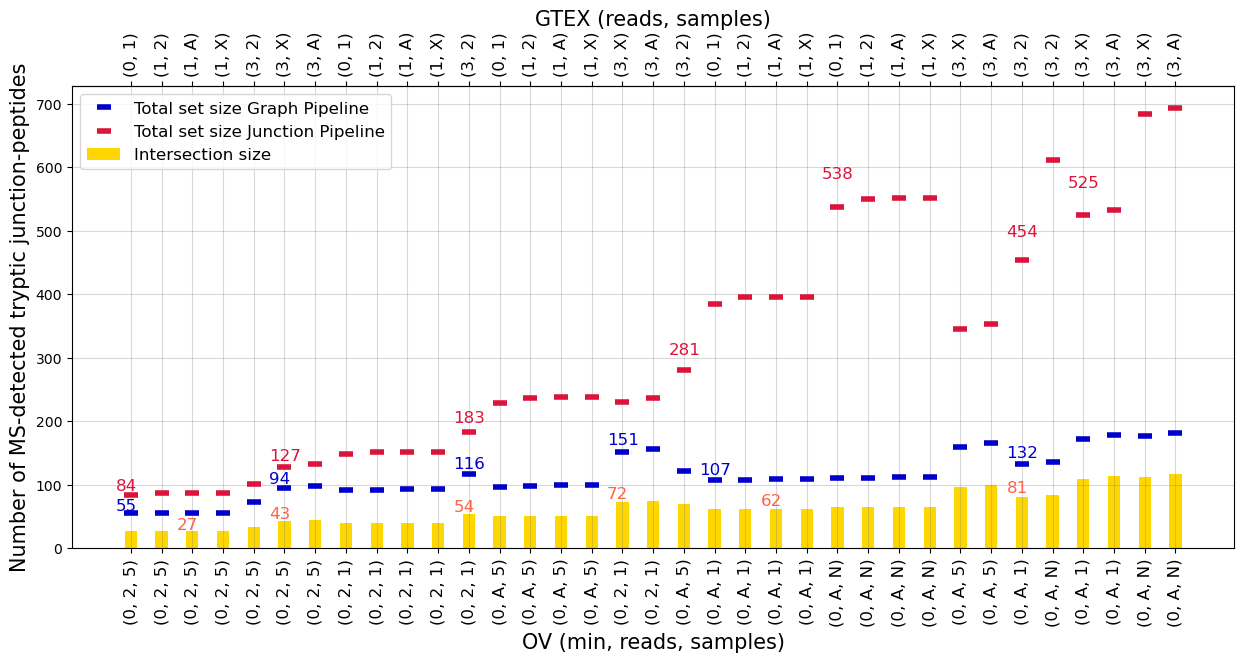

In [8]:
# TMP CODE single sample
path_data = os.path.join(sample_plot_dir[sample], f'data{MS_FDR}_{MS_strategy}.tsv.gz')
print(path_data)
if df is not None:
    df.to_csv(path_data, sep = '\t', index = None)
else:
    df = pd.read_csv(path_data, sep = '\t')
df_plot = run_sample_plotting(sample_plot_dir, sample, df, MS_FDR, MS_strategy, save)

In [9]:
# for sample in all_samples:
#     path_data = os.path.join(sample_plot_dir[sample], f'data{MS_FDR}_{MS_strategy}.tsv.gz')
#     print(path_data)
#     if df is not None:
#         df.to_csv(path_data, sep = '\t', index = None)
#     else:
#         df = pd.read_csv(path_data, sep = '\t')
#     run_sample_plotting(sample_plot_dir, sample, df, MS_FDR, MS_strategy, save)